# Setup

In [1]:
###notebook should run in Google colab

In [2]:
!git clone https://github.com/GPflow/GPflow.git
##only keep the gpflow code folder, none of the metadata
!mv ./GPflow/gpflow ./
!rm -rf GPflow
!pip install multipledispatch

Cloning into 'GPflow'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 19578 (delta 22), reused 21 (delta 12), pack-reused 19514
Receiving objects: 100% (19578/19578), 65.28 MiB | 19.91 MiB/s, done.
Resolving deltas: 100% (14248/14248), done.


In [3]:
import numpy as np
import pandas as pd
import datetime
from google.colab import files
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow_probability import distributions as tfd
import seaborn as sns
import gpflow as gpf
import scipy.optimize
import matplotlib.tri as tri
import matplotlib.ticker
tfk.backend.set_floatx('float64')
gpf.config.set_default_float(np.float64)
matplotlib.rcParams.update({'font.size': 16})


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def rosenbrock(x_arr):
    x_arr = np.array(x_arr).reshape(-1)
    res = 100*np.sum((x_arr[1:] - x_arr[:-1]**2)**2) + np.sum((x_arr[:-1]-1)**2) 
    return res

In [5]:
def prod_of_sines(x_arr):
    x = np.array(x_arr).reshape(-1)
    return np.sin(x[0])*np.product(np.sin(x))

In [6]:
class Embedding_Environment():
    def __init__(self, objective_func, mapping='linear', num_x_dim=5, num_z_dim=2, num_data=10, num_recon_data=2000, noise_std=1e-2):
        self.objective_func = objective_func
        self.mapping = mapping
        self.num_x_dim = num_x_dim
        self.num_z_dim = num_z_dim
        self.num_data = num_data
        self.num_recon_data = num_recon_data
        self.noise_std = noise_std              
        self.create_data()
    
    def center_Z(self,Z_raw): ##Z raw [0,2pi], then width and bias = pi
        return (Z_raw-self.bias)/self.width

    def map_to_X(self, Z):
        Z_tmp = self.center_Z(Z) ##z_tmp between -1 and 1
        if self.mapping == 'nonlinear':
            Z_tmp = np.arctanh(Z_tmp)
        X = Z_tmp @ self.R
        X = X/self.c ##make X between -1 and 1
        return X
    
    def map_to_Z(self, X):
        if self.mapping=='linear':
            return self.width*(self.c* X @ self.R.T) + self.bias
        if self.mapping=='nonlinear':
            return self.width*np.tanh(self.c*(X @ self.R.T)) + self.bias

    def evaluate(self, X):
      Z = self.map_to_Z(X)
      return np.apply_along_axis(self.objective_func, 1, Z)

    def create_data(self):
        ##generate orthogonal R
        H = np.random.randn(self.num_x_dim, self.num_x_dim)
        Q, _ = np.linalg.qr(H)        
        self.R = Q[:self.num_z_dim,:]     

        ##get c, needed for map_to_X
        large_N = self.num_data + self.num_recon_data ##to get the accurate bounds for X
        Z_large = np.random.uniform(-self.width, self.width,size=(large_N,self.num_z_dim)) + self.bias  
        Z_tmp = self.center_Z(Z_large)
        if self.mapping == 'nonlinear':
            Z_tmp = np.arctanh(Z_tmp)
        X = Z_tmp @ self.R ##to get constant c
        self.c = np.max(np.abs(X))                        

        ##can now use map_to_X            
        X_large = self.map_to_X(Z_large) 

        X = X_large[:self.num_data]                   
        Z = Z_large[:self.num_data] 
        f = self.evaluate(X)
        Y = f + self.noise_std * np.random.randn(*tuple(f.shape))

        self.X = X
        self.Y = Y
        self.Z = Z
        self.f = f
        self.X_recon = X_large[self.num_data:]                   

        assert np.allclose(self.map_to_Z(X), Z), "Linear mapping violated"
        assert np.allclose(self.map_to_X(Z), X), "Linear mapping violated"
        assert np.allclose(self.evaluate(X), f), "Linear mapping violated"
        assert np.alltrue((X_large >= -1) & (X_large <= 1)), "generated X out of bounds"

In [7]:
class Rosenbrock_embeddedX(Embedding_Environment):

    def __init__(self, mapping='linear', num_x_dim=5, num_z_dim=2, num_data=10, num_recon_data=2000, noise_std=1e-2):
        self.width = 2.048 
        self.bias = 0      
        super().__init__(rosenbrock, mapping, num_x_dim, num_z_dim, num_data, num_recon_data, noise_std)

In [8]:
class ProductSines_embeddedX(Embedding_Environment):

    def __init__(self, mapping='linear', num_x_dim=5, num_z_dim=2, num_data=10, num_recon_data=2000, noise_std=1e-2):
        self.width = np.pi
        self.bias = np.pi 
        super().__init__(prod_of_sines, mapping, num_x_dim, num_z_dim, num_data, num_recon_data, noise_std)

In [9]:
def show_model(m):
  N,D = m.data[0].shape
  if hasattr(m, 'X_recon_training'):
      N_recon = m.X_recon_training.shape[0]
  else:
      N_recon = N
  print(f"Data Points: {N}")  
  print(f"kernel variance: {np.round(m.kernel.variance.numpy(),3)}")  
  print(f"kernel lengthscales: {np.round(m.kernel.lengthscales.numpy(),3)}")  
  print(f"likelihood variance: {np.round(m.likelihood.variance.numpy(),6)}")
  print(f"*Marginal loglikelihood: {np.round(m.log_marginal_likelihood().numpy(),3)}. Average: {np.round(m.log_marginal_likelihood().numpy()/N,3)}")
  print(f"*Reconstruction loss: {np.round(m.reconstruction().numpy(),3)}. Average:{np.round(m.reconstruction().numpy()/(N_recon*D),5)} ")

In [10]:
def copy_model(model):
    ##deep copy of model
    kernel = gpf.kernels.SquaredExponential(variance = model.kernel.variance, lengthscales = model.kernel.lengthscales)
    new_model = autoencoderGP(model.data, model.X_recon_training, model.Z_recon_training, model.hidden_dim, model.num_z_dim, kernel, model.loss_scaling)
    new_model.likelihood = gpf.likelihoods.Gaussian(model.likelihood.variance)
    new_model.encoder.set_weights(model.encoder.get_weights())
    new_model.decoder.set_weights(model.decoder.get_weights())
    new_model.loss_scaling = model.loss_scaling
    new_model.normalize_Y = model.normalize_Y
    return new_model

In [11]:
##get all permutations of edges in d-dimensions
def z_space_edges(d):
    if d==1:
      return np.array([1,-1]).reshape(2,1)
    else:
      res = z_space_edges((d-1))
      res_pos = np.hstack([np.ones(res.shape[0]).reshape(res.shape[0],1),res])
      res_neg = np.hstack([-np.ones(res.shape[0]).reshape(res.shape[0],1),res])
      return np.vstack([res_pos,res_neg])

In [12]:
def process_Y(Y, normalize):
    if normalize:
        #return (Y-np.mean(Y[:num_data]))/np.std(Y[:num_data])  ##technically less biased
        return (Y-np.mean(Y))/np.std(Y)
    return Y

# Plotting Functions

In [13]:
def plot_logregret(Y, min, label="AE", figsize=[6,4]):
    plt.figure(figsize=figsize)
    ##expects Y to be (num_trials by num_iterations)
    num_trials=Y.shape[0]
    logregret = np.log10(np.minimum.accumulate(Y, axis=1) - min)
    logregret_mean = logregret.mean(0)
    logregret_sd = np.sqrt(logregret.var(0))
    logregret_min = logregret_mean - logregret_sd/np.sqrt(num_trials)
    logregret_max = logregret_mean + logregret_sd/np.sqrt(num_trials)
    plt.plot(range(1, Y.shape[1]+1), logregret_mean, color='red', label=label)
    plt.fill_between(range(1, Y.shape[1]+1), logregret_min, logregret_max, alpha=0.33, color='lightblue')
    plt.title(r'Mean, $\pm \sigma / \sqrt{n}$ ')
    plt.legend()
    plt.show()
def plot_datafit(model, figsize = [20,5]):
    ## X is N by D
    X, Y = model.data[0].numpy(), model.data[1].numpy().reshape(-1,1)
    z_hat = model.encode(X).numpy()
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=figsize)

    sort_idx = np.argsort(z_hat[:,0])
    Z_section = z_hat[:,0][sort_idx]

    Y_mu, Y_var = model.predict_f(X[sort_idx])
    ax1.errorbar(Z_section, Y_mu.numpy() - Y[sort_idx], yerr=2*np.sqrt(Y_var).reshape(-1), fmt='o', alpha=1, label=r'2$\sigma$ errorbar')
    ax1.set_title(r'$\mu(f)$ - Y', fontsize=20)
    ax1.set_xlabel(r'$\hat{z}_1$',fontsize=18)
    ax1.set_ylabel(r'$\mu(f)$ - Y',fontsize=18)

    ax1.legend(prop={'size': 18})

    sort_idx = np.argsort(z_hat[:,1])
    Z_section = z_hat[:,1][sort_idx]

    Y_mu, Y_var = model.predict_f(X[sort_idx])

    ax2.errorbar(Z_section, Y_mu.numpy() - Y[sort_idx], yerr=2*np.sqrt(Y_var).reshape(-1), fmt='o', alpha=1, label=r'2$\sigma$ errorbar')
    ax2.set_title(r'$\mu(f)$ - Y', fontsize=20)
    ax2.set_xlabel(r'$\hat{z}_2$',fontsize=18)
    ax2.set_ylabel(r'$\mu(f)$ - Y',fontsize=18)
    ax2.legend(prop={'size': 18})

    plt.show()

def plot_GPR_contour(model, hdbo_env, figsize=[20,5], acquisition_method_toshow="EI", Z_min=-1, Z_max=1, show_optim = True, **kwargs):
    X = model.data[0].numpy()
    next_z_candidate, _ = get_next_candidate(model, Z_min, Z_max, acquisition_method_toshow, 100, 5000, **kwargs)
    z_optim = model.encode(hdbo_env.map_to_X(np.ones(num_z_dim)).reshape(1,-1))
    z_hat = model.encode(X).numpy()
    
    z_plotspace = np.random.uniform(Z_min, Z_max,size=(5000,num_z_dim))
    z_reachable = model.encode(model.decode(z_plotspace)).numpy()
    x = z_reachable[:,0]
    y = z_reachable[:,1]
    f_mu, f_var = model.predict_f_Z(z_reachable)
    f_mu = f_mu.numpy().reshape(-1)
    f_var = f_var.numpy().reshape(-1)

    fig, (ax1,ax2) = plt.subplots(1, 2, sharey=False, figsize=figsize)

    ####AX1
    ax1.tricontour(x, y, f_mu, levels=14, linewidths=0.5, colors='k')
    cntr2 = ax1.tricontourf(x, y, f_mu, levels=14, cmap="RdBu_r")

    #plot points    
    ax1.plot(z_hat[:,0], z_hat[:,1], 'ko', ms=5, label=r'$\hat{z}$ (Encoded X)',alpha=0.8)
    ax1.plot(next_z_candidate[0], next_z_candidate[1], 'ko', marker='*', ms=20, label=r'next $\hat{z}$ (Encoded X)',alpha=0.8, color = 'gold')
    # if show_optim:
    #     ax1.plot(z_optim[:,0], z_optim[:,1], 'ko', marker='*', ms=20, label=r'optimal ${z}_*$ (Encoded X*)',alpha=0.8, color = 'red')
    ax1.legend()

    fig.colorbar(cntr2, ax=ax1)
    ax1.set_title(r'$\mu(f)$ contour plot (z-space)')

    ax1.set_xlabel(r'$\hat{z}_1$',fontsize=20)
    ax1.set_ylabel(r'$\hat{z}_2$',fontsize=20)

    ax1.set_xlim(-1,1)
    ax1.set_ylim(-1,1)

    ######AX2
    ax2.tricontour(x, y, f_var, levels=20, linewidths=0.5, colors='k')
    cntr2 = ax2.tricontourf(x, y, f_var, levels=14, cmap="RdBu_r",locator=matplotlib.ticker.LogLocator())

    ax2.plot(z_hat[:,0], z_hat[:,1], 'ko', ms=5, label=r'$\hat{z}$ (Encoded X)',alpha=0.8)
    ax2.plot(next_z_candidate[0], next_z_candidate[1], 'ko', ms=20, marker='*', label=r'next $\hat{z}$ (Encoded X)',alpha=0.8, color = 'gold')
    # if show_optim:
    #     ax2.plot(z_optim[:,0], z_optim[:,1], 'ko', marker='*', ms=20, label=r'optimal ${z}_*$ (Encoded X*)',alpha=0.8, color = 'red')
    ax2.legend()

    fig.colorbar(cntr2, ax=ax2)
    ax2.set_title(r'Var$(f)$ contour plot (z-space)')
    
    ax2.set_xlabel(r'$\hat{z}_1$',fontsize=20)
    ax2.set_ylabel(r'$\hat{z}_2$',fontsize=20)

    ax2.set_xlim(-1,1)
    ax2.set_ylim(-1,1)

def plot_reconstruction_scatter(model, num_rows=3, num_cols=2, figsize=[16,12]):
    ##X is N by D
    X = model.X_recon_training
    fig, axes = plt.subplots(num_rows, num_cols, sharey=False, figsize=figsize)
    X_hat = model.decode(model.encode(X))
    counter = 0
    for i in range(num_rows):
        for j in range(num_cols):
            if counter < X.shape[1]:
                axes[i,j].scatter(X[:,counter], X_hat[:,counter],alpha=0.8, label=r'${{x}}_{{{}}}, \hat{{x}}_{{{}}}$'.format(counter+1,counter+1))
                axes[i,j].set_xlabel(r'$X$',fontsize=15)
                axes[i,j].set_ylabel(r'$\hat{X}$',fontsize=15)
                axes[i,j].legend(fontsize=15)
                counter+=1
    plt.show()

def plot_Z_reconstruction_scatter(model, Z=None, figsize=[16,4], levels=14):
    if Z is None:
        Z = model.Z_recon_training
    fig, axes = plt.subplots(1, 2, sharey=False, figsize=figsize)
    Z_hat = model.encode(model.decode(Z))

    axes[0].scatter(Z[:,0], Z_hat[:,0],alpha=0.2, label=r'$z_{{{}}},h(g(z_{{{}}}))$'.format(1,1))
    axes[0].set_xlabel(r'$Z$',fontsize=18)
    axes[0].set_ylabel(r'$h(g(Z))$',fontsize=18)
    axes[0].legend(fontsize=18)

    axes[1].scatter(Z[:,1], Z_hat[:,1],alpha=0.2, label=r'$z_{{{}}},h(g(z_{{{}}}))$'.format(2,2))
    axes[1].set_xlabel(r'$Z$',fontsize=18)
    axes[1].set_ylabel(r'$h(g(Z))$',fontsize=18)
    axes[1].legend(fontsize=18)

    fig.suptitle(r"$h(g(Z))$ vs. $Z$", fontsize="x-large")


def plot_feature_space(model, figsize=[10,6], show_data = False, levels=14):

    x_plotspace = np.vstack([model.data[0], model.X_recon_training])
    z_featurespace = model.encode(x_plotspace)

    f = hdbo_env.evaluate(x_plotspace)

    x = z_featurespace[:,0]
    y = z_featurespace[:,1]

    fig, ax = plt.subplots(figsize=figsize)

    ####AX1
    ax.tricontour(x, y, f, levels, linewidths=0.5, colors='k')
    cntr2 = ax.tricontourf(x, y, f, levels, cmap="RdBu_r") #,locator=matplotlib.ticker.LogLocator())

    fig.colorbar(cntr2, ax=ax)
    ax.set_title(r'f(X) contour over $h(X)$: using X recon data and X from BO',fontsize=20)

    if show_data:
        z_hat_data = model.encode(model.data[0]).numpy()
        ax.scatter(z_hat_data[:, 0],z_hat_data[:, 1], color='black')

    ax.set_xlabel(r'$\hat{z}_1$',fontsize=20)
    ax.set_ylabel(r'$\hat{z}_2$',fontsize=20)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)

# AEGP model


In [14]:
class autoencoderGP(gpf.models.GPR):

    def __init__(self, data, X_recon_training, Z_recon_training, hidden_dim, num_z_dim, kernel, loss_scaling = (1,1,1), normalize_Y = False):
        super().__init__(data, kernel)  # always call the parent constructor
        self.X_recon_training = X_recon_training
        self.Z_recon_training = Z_recon_training
        self.hidden_dim = hidden_dim
        self.num_z_dim = num_z_dim
        self.num_data, self.input_dim = data[0].shape
        self.loss_scaling = loss_scaling
        self.normalize_Y = normalize_Y ##set to true if input Y has been normalized

        self.encoder = tfk.Sequential([
                      tfk.layers.Dense(hidden_dim,kernel_initializer='he_normal', input_shape = (self.input_dim,)),
                      tfk.layers.LeakyReLU(alpha=0.1),                                          
                      tfk.layers.Dense(num_z_dim),
                      tfk.layers.Activation('tanh')
                      ])

        self.decoder = tfk.Sequential([
                      tfk.layers.Dense(hidden_dim,kernel_initializer='he_normal', input_shape = (num_z_dim,)),
                      tfk.layers.LeakyReLU(alpha=0.1),                                                            
                      tfk.layers.Dense(self.input_dim),
                      tfk.layers.Activation('tanh')
                      ])

    def encode(self, X):
        return self.encoder(X)

    def decode(self, Z):
        return self.decoder(Z)
    
    def log_marginal_likelihood(self):

        X, Y = self.data        

        z_hat = self.encode(X)
        K = self.kernel(z_hat)
        num_data = z_hat.shape[0]
        k_diag = tf.linalg.diag_part(K)
        s_diag = tf.fill([num_data], self.likelihood.variance)
        ks = tf.linalg.set_diag(K, k_diag + s_diag)
        L = tf.linalg.cholesky(ks)
        m = self.mean_function(X)

        # [R,] log-likelihoods for each independent dimension of Y
        log_prob = gpf.logdensities.multivariate_normal(Y, m, L)
        return tf.reduce_sum(log_prob)

    def reconstruction(self):
        # X = self.X_recon_training
        X = np.vstack([self.data[0], self.X_recon_training])
        X_hat = self.decode(self.encode(X))

        return tf.reduce_sum(tf.square(tf.subtract(X_hat, X))) ##using reduce_sum instead of reduce_mean scales by size of X: N*D

    def reconstruction_Z(self):
        Z = self.Z_recon_training
        Z_hat = self.encode(self.decode(Z))
        
        return tf.reduce_sum(tf.square(tf.subtract(Z_hat, Z))) ##using reduce_sum instead of reduce_mean scales by size of X: N*D

    def predict_f(
        self, Xnew, full_cov = False, full_output_cov = False):
        r"""
        This method computes predictions at X \in R^{N \x D} input points

        .. math::
            p(F* | Y)

        where F* are points on the GP at new data points, Y are noisy observations at training data points.
        """
        
        z_hat_new = self.encode(Xnew)
        return self.predict_f_Z(z_hat_new, full_cov=full_cov, full_output_cov=full_output_cov)

    def predict_f_Z(
        self, z_hat_new, full_cov = False, full_output_cov = False):
        r"""
        This method computes predictions at X \in R^{N \x D} input points

        .. math::
            p(F* | Y)

        where F* are points on the GP at new data points, Y are noisy observations at training data points.
        """
        X_data, Y_data = self.data
        z_hat = self.encode(X_data)
        err = Y_data - self.mean_function(z_hat)

        kmm = self.kernel(z_hat)
        knn = self.kernel(z_hat_new, full_cov=full_cov)
        kmn = self.kernel(z_hat, z_hat_new)

        num_data = z_hat.shape[0]
        s = tf.linalg.diag(tf.fill([num_data], self.likelihood.variance))

        conditional = gpf.conditionals.base_conditional
        f_mean_zero, f_var = conditional(
            kmn, kmm + s, knn, err, full_cov=full_cov, white=False
        )  # [N, P], [N, P] or [P, N, N]
        f_mean = f_mean_zero + self.mean_function(z_hat_new)
        return f_mean, f_var

    def _training_loss(self, *args, **kwargs):
        """
        Training loss definition. To allow MAP (maximum a-posteriori) estimation,
        adds the log density of all priors to maximum_log_likelihood_objective().
        """
        return -(self.maximum_log_likelihood_objective(*args, **kwargs) + self.log_prior_density())*self.loss_scaling[0] + self.reconstruction()*self.loss_scaling[1] + self.reconstruction_Z()*self.loss_scaling[2]

In [15]:
def GPR_set_trainable(model, trainable_bool):
    gpf.utilities.set_trainable(model.likelihood.variance, trainable_bool)
    gpf.utilities.set_trainable(model.kernel.variance, trainable_bool)
    gpf.utilities.set_trainable(model.kernel.lengthscales, trainable_bool)

@tf.autograph.experimental.do_not_convert
def optimization_step(model, optim, freeze_autoencoder):
    training_loss = model.training_loss_closure()
    if freeze_autoencoder:
      ##only train gp
      var_list = list(model.kernel.trainable_variables)
      var_list.append((model.likelihood.trainable_variables))
      optim.minimize(training_loss, var_list=tuple(var_list))
    else:
      optim.minimize(training_loss, var_list=model.trainable_variables)

def optimize_GPR_AE(model, num_epochs=1000, lr=3e-2, lengthscale_threshold=0.3, logging_epoch_freq = 500, freeze_autoencoder = False):
    compiled_optim_step = tf.function(optimization_step)

    adam_opt = tf.optimizers.Adam(lr)
    N = model.data[0].shape[0]
    frozen_GPR = False

    for i in range(num_epochs):
        if (i % logging_epoch_freq == 0) and (i > 0):
            tf.print(f"Epoch {i}: NegLogLik + ReconLoss {model.training_loss().numpy()} , NLL: {-model.log_marginal_likelihood()}, X-ReconLoss: {model.reconstruction()}, Z-ReconLoss: {model.reconstruction_Z()} Lengthscale: {model.kernel.lengthscales.numpy().mean()}")

        if (not frozen_GPR) and model.kernel.lengthscales.numpy().mean() < lengthscale_threshold:
          tf.print("Turning off GP training")
          GPR_set_trainable(model, False)
          frozen_GPR = True
          compiled_optim_step = tf.function(optimization_step)
        
        compiled_optim_step(model, adam_opt, freeze_autoencoder)

    tf.print(f"Final: NegLogLik + ReconLoss {model.training_loss().numpy()} , NLL: {-model.log_marginal_likelihood()}, ReconLoss: {model.reconstruction()}, Z-ReconLoss: {model.reconstruction_Z()}, Lengthscale: {model.kernel.lengthscales.numpy().mean()}")

# Bayesian Optimization

In [50]:
def ExpectedImprovement(Z, model, fmin_offset = 0):
    fmin = np.min(model.data[1]) - fmin_offset
    candidate_mean, candidate_var = model.predict_f_Z(tf.reshape(Z,[-1,num_z_dim]))
    sigma = tf.sqrt(candidate_var)
    Z_score = (fmin - candidate_mean)/sigma

    normal = tfd.Normal(tf.cast(0,dtype='float64'), 1)
    t1 = (fmin - candidate_mean) * normal.cdf(Z_score)
    t2 = sigma * normal.prob(Z_score)
    EI = t1 + t2
    return tf.reshape(EI, [-1])

def ProbabilityImprovement(Z, model, fmin_offset = 0):
    fmin = np.min(model.data[1]) - fmin_offset
    candidate_mean, candidate_var = model.predict_f_Z(tf.reshape(Z,[-1,num_z_dim]))
    sigma = tf.sqrt(candidate_var)
    Z_score = (fmin - candidate_mean)/sigma

    normal = tfd.Normal(tf.cast(0,dtype='float64'), 1)
    PI = normal.cdf(Z_score)
    return tf.reshape(PI, [-1])

def UpperConfidenceBound(Z, model, delta=0.1):
    discrete_cardinality_D = 5000
    iteration = len(model.data[0]) - model.num_data + 1
    beta_t = 2*np.log(discrete_cardinality_D*(iteration**2)*(np.pi**2)/(6*delta))
    candidate_mean, candidate_var = model.predict_f_Z(tf.reshape(Z,[-1,num_z_dim]))
    UCB = -candidate_mean + np.sqrt(beta_t)*tf.sqrt(candidate_var)
    return tf.reshape(UCB, [-1])

def acquisition_func(Z, model, method="EI", *args):
    Z = tf.reshape(tf.convert_to_tensor(Z, dtype=tf.float64), [-1,num_z_dim])    
    if method == "EI":
      Acquisition = ExpectedImprovement
    elif method == "PI":
      Acquisition = ProbabilityImprovement
    elif method == "UCB":
      Acquisition = UpperConfidenceBound
    else:
      raise NotImplementedError
    return Acquisition(Z, model,*args)

def optimize_acquisition(Z, model, method="EI", *args):
    Z = tf.reshape(tf.convert_to_tensor(Z, dtype=tf.float64),  [-1,num_z_dim])
    
    ##calculate maxEI and the gradient d(maxEI)/dZ
    with tf.GradientTape() as t:
      t.watch(Z)
      Alpha = acquisition_func(Z, model, method,*args)
      sumAlpha = tf.reduce_sum(Alpha)
    grad = t.gradient(sumAlpha,Z)

    ##negative to maximize acquisition function, not minimize
    return -sumAlpha.numpy(), -grad.numpy().reshape(-1)
    
def get_next_candidate(model, Z_minval = -1, Z_maxval = 1, acquisition_method = "EI", N_initial_guess = 100, N_random_search = 5000, **acquisition_params):
    acquisition_params = tuple(acquisition_params.values()) ##convert dictionary of input params to tuple
    ##1. pick 5000 random points. select best 100 points 
    z_edges=z_space_edges(num_z_dim)
    Z_randomsearch = np.vstack([z_edges, np.random.uniform(Z_minval,Z_maxval, size=(N_random_search, num_z_dim))])    
    Z_randomsearch = model.encode(model.decode(Z_randomsearch)) ##cutoff unreachable
    alpha_randomsearch = acquisition_func(Z_randomsearch, model, acquisition_method, *acquisition_params).numpy()
    top_idx = np.argsort(alpha_randomsearch.reshape(-1))[-N_initial_guess:]
    z0 = Z_randomsearch.numpy()[top_idx] ##top 100 best acquisition# ##shape (N, num_z_dim)

    ##2. run L-BFGS from those 100 points as initializers
    result = scipy.optimize.minimize(optimize_acquisition, z0.reshape(-1), args=(model, acquisition_method, *acquisition_params, ), jac=True, method='l-bfgs-b', bounds=[(Z_minval,Z_maxval)]*num_z_dim*N_initial_guess, options=dict(maxiter=1000))
    next_z = result.x.reshape(-1,num_z_dim) ##shape (N,num_z_dim)

    #3. check L-BFGS didn't go to extremes, if it did, revert to z0
    lower_bound = np.min(Z_randomsearch, axis=0) ##LB for each z dimension
    upper_bound = np.max(Z_randomsearch, axis=0)
    valid_lbfgs = np.product((next_z > lower_bound) * (next_z < upper_bound),axis=1).reshape(-1,1)
    valid_lbfgs_mask = np.hstack([valid_lbfgs]*num_z_dim)
    next_z = valid_lbfgs_mask*next_z + (1-valid_lbfgs_mask)*z0

    # ##3. take best from L-BFGS optimized
    next_z_candidate = next_z[np.argmax(acquisition_func(next_z, model, acquisition_method, *acquisition_params))]
    next_x_candidate = model.decode(next_z_candidate.reshape(-1,num_z_dim)).numpy().reshape(-1)

    return next_z_candidate, next_x_candidate
def x_star_reconstruction_loss(model, next_x_candidate):
    next_x_candidate = next_x_candidate.reshape(-1,num_x_dim)
    X_hat = model.decode(model.encode(next_x_candidate))
    return tf.reduce_sum(tf.square(tf.subtract(X_hat, next_x_candidate)))

@tf.autograph.experimental.do_not_convert
def finetune_step_mGP(model, optim, next_x_candidate):
    def loss_func():
        weight=1e4 ##how many times more important is x* vs regular x, for reconstruction purpose
        X_hat = model.decode(model.encode(next_x_candidate))
        return model.reconstruction() + tf.reduce_sum(tf.square(tf.subtract(X_hat, next_x_candidate)))*len(model.X_recon_training)*weight

    optim.minimize(loss_func, var_list=tuple(model.encoder.trainable_variables))

def finetune_mGP(model, next_x_candidate, num_epochs=1000, lr=1e-4, logging_epoch_freq = 500):
    
    next_x_candidate = next_x_candidate.reshape(-1,num_x_dim)
    compiled_optim_step = tf.function(finetune_step_mGP)
    adam_opt = tf.optimizers.Adam(lr)

    tf.print(f"Before fine-tuning: x_star_reconstruction {x_star_reconstruction_loss(model, next_x_candidate)},  NegLogLik + ReconLoss {model.training_loss().numpy()} , NLL: {-model.log_marginal_likelihood()}, X-ReconLoss: {model.reconstruction()}, Z-ReconLoss: {model.reconstruction_Z()}, Lengthscale: {model.kernel.lengthscales.numpy().mean()}")

    for i in range(num_epochs):
        compiled_optim_step(model, adam_opt, next_x_candidate)

    tf.print(f"After fine-tuning: x_star_reconstruction {x_star_reconstruction_loss(model, next_x_candidate)},  NegLogLik + ReconLoss {model.training_loss().numpy()} , NLL: {-model.log_marginal_likelihood()}, X-ReconLoss: {model.reconstruction()}, Z-ReconLoss: {model.reconstruction_Z()}, Lengthscale: {model.kernel.lengthscales.numpy().mean()}")

def run_HDBO(model_input, hdbo_env, num_iter = 10, acquisition_method = "EI", LS_threshold=0, num_epochs=2000, lr=1e-2, sticky_autoencoder=False, **acquisition_params):

    X,Y = model_input.unnorm_data

    model = copy_model(model_input) ##deep copy    
    X_recon_training, Z_recon_training = model.X_recon_training, model.Z_recon_training
    loss_scaling=model.loss_scaling
    normalize_Y = model.normalize_Y

    for iteration in range(num_iter):
        
        if iteration % 10 == 0:
            show_model(model)
            print(np.min(hdbo_env.evaluate(model.data[0])))

        ################acquisition
        next_z_candidate, next_x_candidate = get_next_candidate(model, -1, 1, acquisition_method, 100, 5000, **acquisition_params)
        finetune_mGP(model, next_x_candidate, num_epochs=1000, lr=1e-4, logging_epoch_freq=1000)
        next_z_candidate, next_x_candidate = get_next_candidate(model, -1, 1, acquisition_method, 100, 5000, **acquisition_params)

        new_Y = hdbo_env.evaluate(next_x_candidate.reshape(1,-1)) + hdbo_env.noise_std*np.random.randn(1)[0]        
        X = np.vstack((X, next_x_candidate))
        Y = np.append(Y,new_Y)        #unnormalized, since we want all Y to be same scale
        
        ###################re-train GP
        
        ###keep autoencoder weights and biases
        if sticky_autoencoder:          
            model.kernel.variance.assign(1.0)
            model.kernel.lengthscales.assign(1.0)
            #model.kernel.lengthscales.assign(np.ones(num_z_dim)) ##ARD case
            
            #update data
            Y_processed = process_Y(Y, normalize_Y)
            model.data = (tf.convert_to_tensor(X, dtype=tf.float64), tf.convert_to_tensor(Y_processed.reshape(-1,1), dtype=tf.float64))

        else:
            ##reset entire model including AE weights
            kernel = gpf.kernels.SquaredExponential(variance = 1.0, lengthscales = 1.0)
            model = autoencoderGP((X, Y.reshape(-1,1)), X_recon_training, Z_recon_training, model.hidden_dim, model.num_z_dim, kernel, loss_scaling, normalize_Y)
        
        model.likelihood.variance.assign(1e-4)        
        optimize_GPR_AE(model, num_epochs, lr, LS_threshold, 2000, freeze_autoencoder=False)
    
    model.unnorm_data = (tf.convert_to_tensor(X, dtype=tf.float64), tf.convert_to_tensor(Y.reshape(-1,1), dtype=tf.float64))
    return model

# Single Trial

## Create Toy data

In [38]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [40]:
num_x_dim=10
num_hidden = 2
num_z_dim=2
num_data=10
num_recon_data=2000

####USING ISO-TROPIC KERNEL
hdbo_env = ProductSines_embeddedX('linear',num_x_dim, num_z_dim, num_data, noise_std=1e-2,num_recon_data=num_recon_data)
X, Y, Z, X_recon_training = hdbo_env.X, hdbo_env.Y, hdbo_env.Z, hdbo_env.X_recon
z_edges=z_space_edges(num_z_dim)
Z_recon_training = np.vstack([z_edges, np.random.uniform(-1,1, size=(num_recon_data-len(z_edges), num_z_dim))])
np.min(X_recon_training,axis=0),np.max(X_recon_training, axis=0)

(array([-0.31220545, -0.88391243, -0.61613246, -0.37285357, -0.59345989,
        -0.31650515, -0.04462325, -0.83280228, -0.88515776, -0.98355246]),
 array([0.32434075, 0.87627978, 0.60047866, 0.38372969, 0.57846749,
        0.30865472, 0.04365591, 0.82097058, 0.8838365 , 1.        ]))

In [41]:
loss_scaling=(1,1,1)
normalize_Y = True
kernel = gpf.kernels.SquaredExponential() 

Y_processed = process_Y(Y, normalize_Y)
model = autoencoderGP((X, Y_processed.reshape(-1,1)), X_recon_training, Z_recon_training, num_hidden, num_z_dim, kernel, loss_scaling, normalize_Y)
model.likelihood.variance.assign(1e-4)
model.unnorm_data = (X,Y.reshape(-1,1)) ##original, unscaled Y needed for BO 
model

name,class,transform,prior,trainable,shape,dtype,value
autoencoderGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
autoencoderGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
autoencoderGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00010000000000000011
autoencoderGP.encoder._layers[1]._trainable_weights[0] autoencoderGP.encoder._layers[1].kernel,ResourceVariable,,,True,"(10, 2)",float64,"[[0.22670195, 0.73209879..."
autoencoderGP.encoder._layers[1]._trainable_weights[1] autoencoderGP.encoder._layers[1].bias,ResourceVariable,,,True,"(2,)",float64,[0. 0.]
autoencoderGP.encoder._layers[3]._trainable_weights[0] autoencoderGP.encoder._layers[3].kernel,ResourceVariable,,,True,"(2, 2)",float64,"[[-1.02668803, -0.56763263..."
autoencoderGP.encoder._layers[3]._trainable_weights[1] autoencoderGP.encoder._layers[3].bias,ResourceVariable,,,True,"(2,)",float64,[0. 0.]
autoencoderGP.decoder._layers[1]._trainable_weights[0] autoencoderGP.decoder._layers[1].kernel,ResourceVariable,,,True,"(2, 2)",float64,"[[0.73177588, 0.80096..."
autoencoderGP.decoder._layers[1]._trainable_weights[1] autoencoderGP.decoder._layers[1].bias,ResourceVariable,,,True,"(2,)",float64,[0. 0.]
autoencoderGP.decoder._layers[3]._trainable_weights[0] autoencoderGP.decoder._layers[3].kernel,ResourceVariable,,,True,"(2, 10)",float64,"[[0.553831, -0.66602399, 0.54616725..."


In [42]:
%%time
optimize_GPR_AE(model, num_epochs=3000,lr=1e-2, lengthscale_threshold=0, logging_epoch_freq=500, freeze_autoencoder=False)

Epoch 500: NegLogLik + ReconLoss 310.36599390243396 , NLL: 38.95186385131919, X-ReconLoss: 190.85083094544052, Z-ReconLoss: 80.56329910567426 Lengthscale: 0.5136367146183213
Epoch 1000: NegLogLik + ReconLoss 141.06788747534105 , NLL: 14.654357726365987, X-ReconLoss: 77.21321469508707, Z-ReconLoss: 49.200315053888 Lengthscale: 0.4624463052377814
Epoch 1500: NegLogLik + ReconLoss 76.44599669507699 , NLL: 14.844423485939611, X-ReconLoss: 28.015925630146683, Z-ReconLoss: 33.58564757899068 Lengthscale: 0.42056815192630603
Epoch 2000: NegLogLik + ReconLoss 67.5186858489708 , NLL: 13.84478560937058, X-ReconLoss: 25.23196905098488, Z-ReconLoss: 28.441931188615346 Lengthscale: 0.3805677489513953
Epoch 2500: NegLogLik + ReconLoss 64.58114802021743 , NLL: 13.229564239051562, X-ReconLoss: 24.661638021267642, Z-ReconLoss: 26.689945759898222 Lengthscale: 0.34885878300093814
Final: NegLogLik + ReconLoss 62.31759065093479 , NLL: 12.883140198460332, ReconLoss: 23.914411409777223, Z-ReconLoss: 25.520039

## View Initial Model

In [43]:
show_model(model)

Data Points: 10
kernel variance: 1.835
kernel lengthscales: 0.323
likelihood variance: 0.000144
*Marginal loglikelihood: -12.883. Average: -1.288
*Reconstruction loss: 23.914. Average:0.0012 


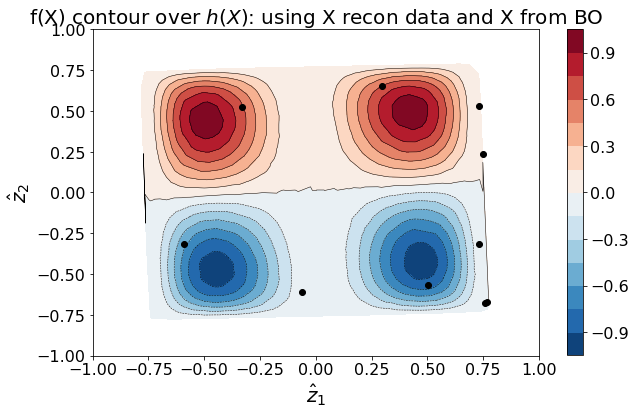

In [44]:
plot_feature_space(model, show_data=True)

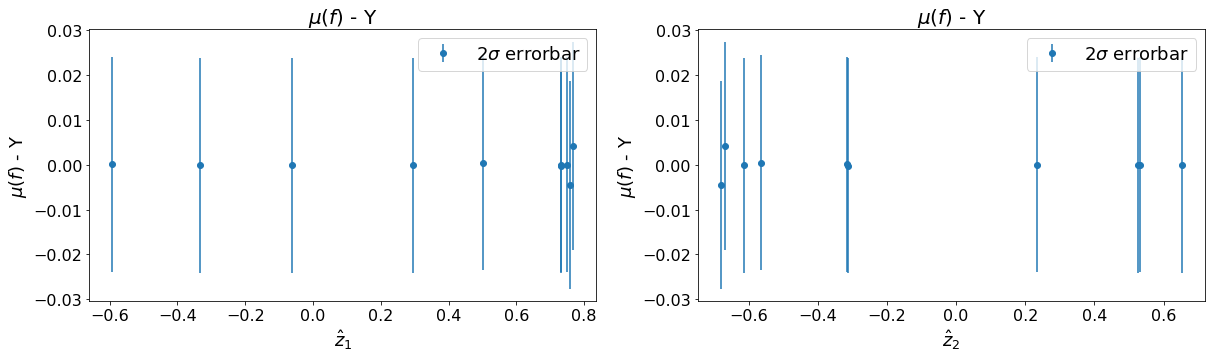

In [45]:
plot_datafit(model)

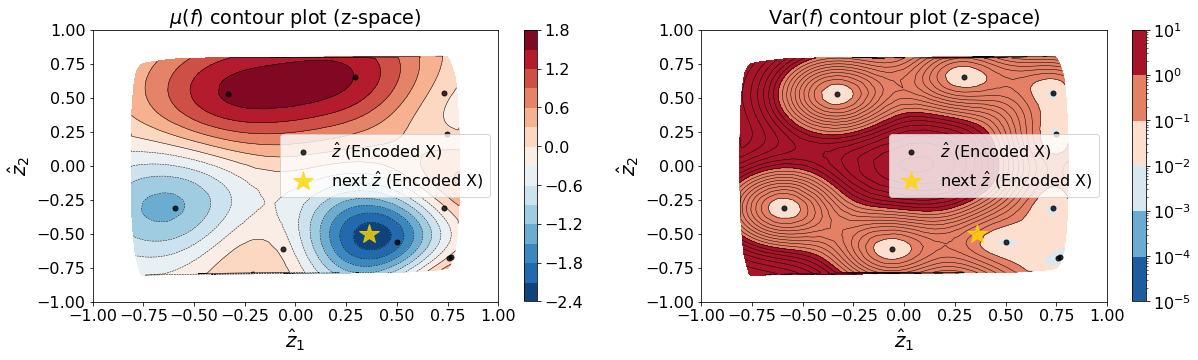

In [46]:
plot_GPR_contour(model, hdbo_env, acquisition_method_toshow="EI")

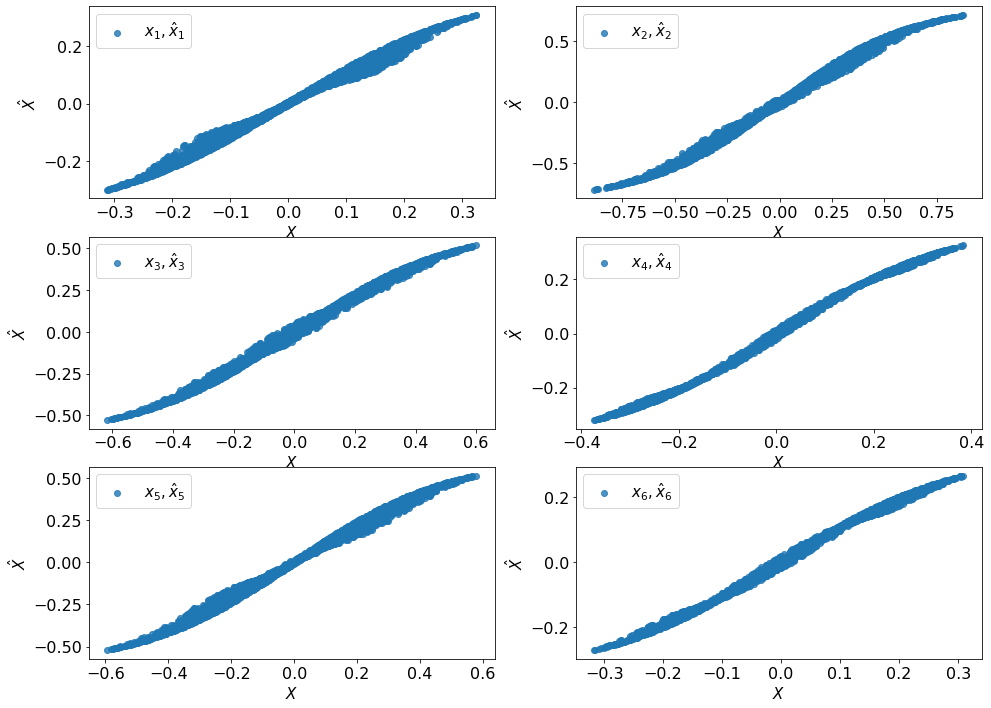

In [47]:
plot_reconstruction_scatter(model, 3, 2)

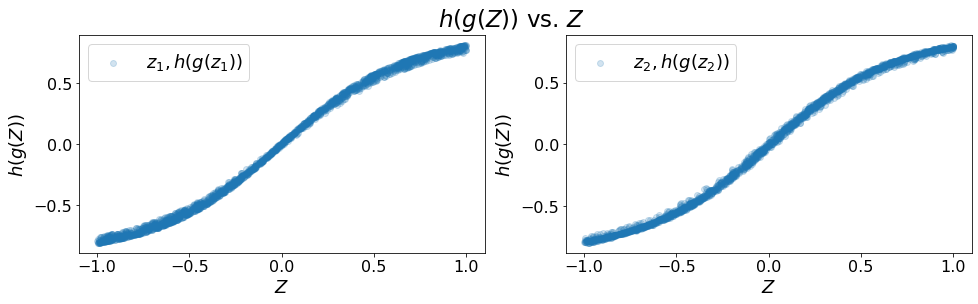

In [48]:
plot_Z_reconstruction_scatter(model,np.random.uniform(-1,1, size=(2000, num_z_dim)))

## B.O. Loop


In [51]:
%%time
np.random.seed(1)
tf.random.set_seed(1)
  
model_BO = run_HDBO(model, hdbo_env, num_iter = 100, acquisition_method = "EI", LS_threshold=0, num_epochs=2000, lr=1e-2, sticky_autoencoder=True, param=0.0)

Data Points: 10
kernel variance: 1.835
kernel lengthscales: 0.323
likelihood variance: 0.000144
*Marginal loglikelihood: -12.883. Average: -1.288
*Reconstruction loss: 23.914. Average:0.0012 
-0.8286520057264931
Before fine-tuning: x_star_reconstruction 0.016246333588334216,  NegLogLik + ReconLoss 62.31759065093479 , NLL: 12.883140198460332, X-ReconLoss: 23.914411409777223, Z-ReconLoss: 25.520039042697235, Lengthscale: 0.32279409605178344
After fine-tuning: x_star_reconstruction 3.98234555284066e-11,  NegLogLik + ReconLoss 87.37143385252496 , NLL: 12.6195518965212, X-ReconLoss: 39.200536038643385, Z-ReconLoss: 35.55134591736037, Lengthscale: 0.32279409605178344
Final: NegLogLik + ReconLoss 28.91027857418987 , NLL: 11.733601432922253, ReconLoss: 12.200598093258849, Z-ReconLoss: 4.976079048008766, Lengthscale: 0.23596402178918738
Before fine-tuning: x_star_reconstruction 0.0004998824490767256,  NegLogLik + ReconLoss 28.91027857418987 , NLL: 11.733601432922253, X-ReconLoss: 12.20059809325

Text(0.5, 1.0, 'D=10, d=2, true min=-10')

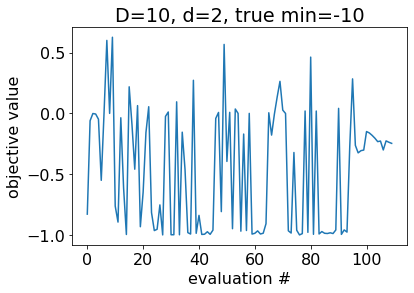

In [52]:
plt.plot(hdbo_env.evaluate(model_BO.data[0].numpy()))
plt.ylabel('objective value')
plt.xlabel('evaluation #')
plt.title(f'D={num_x_dim}, d={num_z_dim}, true min=-10')

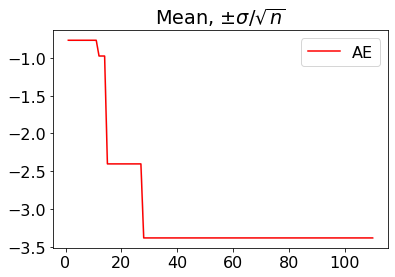

In [54]:
plot_logregret(hdbo_env.evaluate(model_BO.data[0].numpy()).reshape(1,-1), min=-1)

## View Model

In [55]:
show_model(model_BO)

Data Points: 110
kernel variance: 2.082
kernel lengthscales: 0.299
likelihood variance: 0.000198
*Marginal loglikelihood: 77.586. Average: 0.705
*Reconstruction loss: 34.764. Average:0.00174 


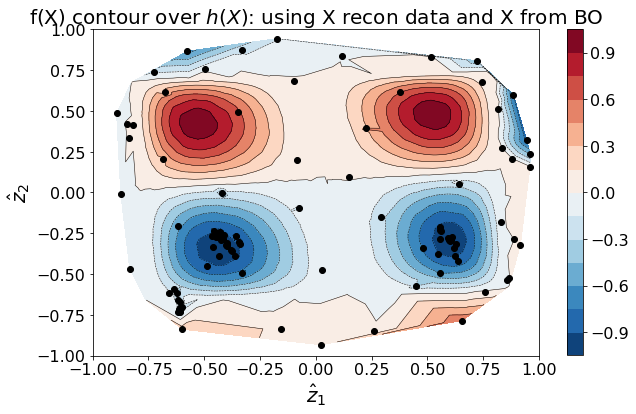

In [56]:
plot_feature_space(model_BO, show_data=True)

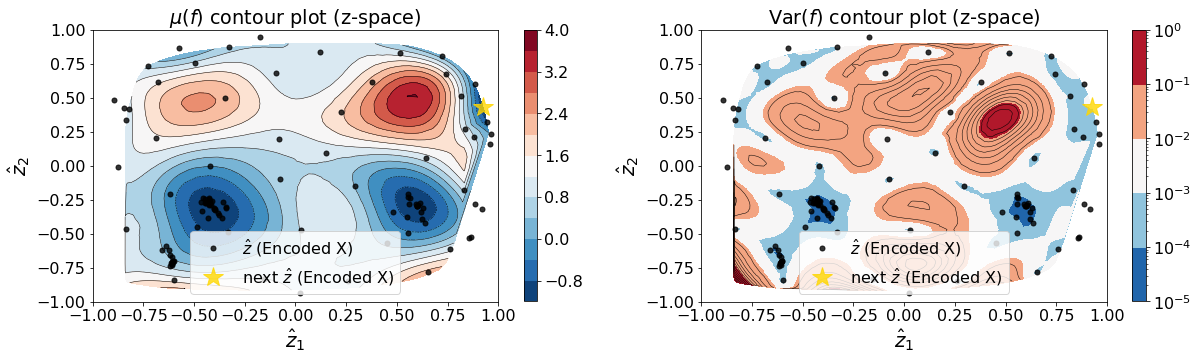

In [57]:
plot_GPR_contour(model_BO, hdbo_env, acquisition_method_toshow="EI", param=0.0)

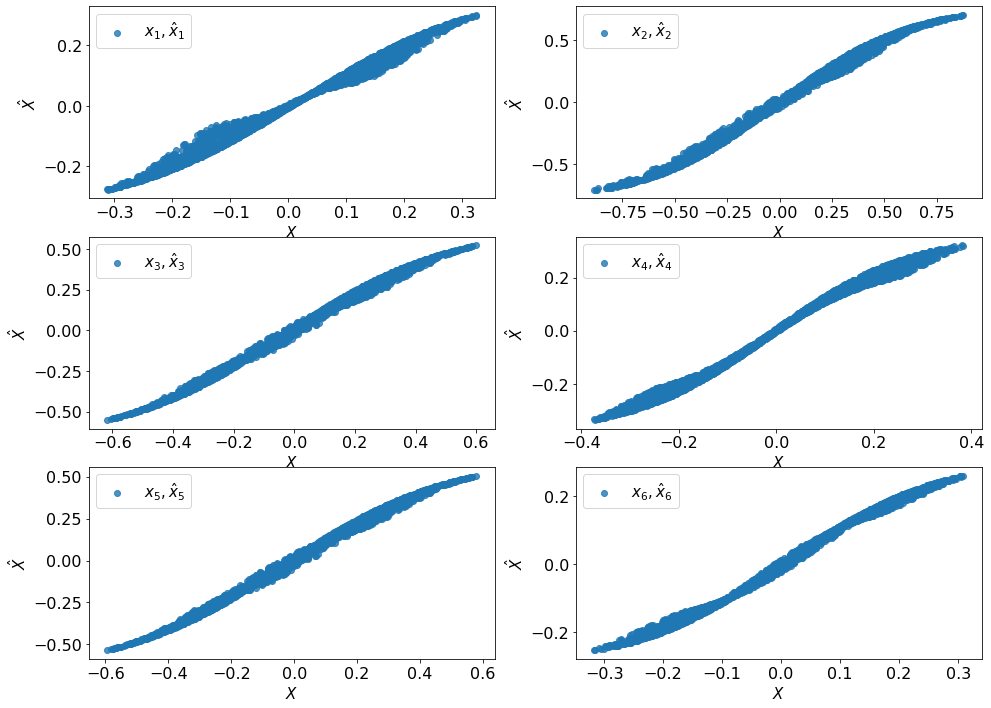

In [58]:
plot_reconstruction_scatter(model_BO, 3, 2)

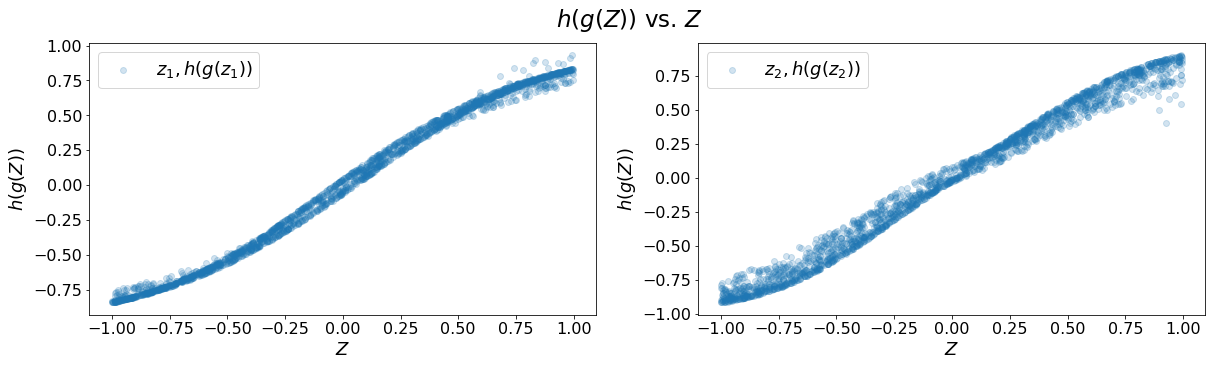

In [59]:
plot_Z_reconstruction_scatter(model_BO,np.random.uniform(-1,1, size=(2000, num_z_dim)), figsize=[20,5])

# Multiple Trials

In [ ]:
##model hyperparams 
num_x_dim=60 
num_hidden = 10
num_z_dim=10
num_data=10 
loss_scaling=(1,1,1)
normalize_Y = True

In [ ]:
##experiment setup
num_epochs=3000 ##optimizing GPAE
lr=1e-2
lengthscale_threshold=0
acquisition_method="EI"
acquisition_param = 0.0
num_recon_data=20000

num_BO_iter=300
num_trials=1
Y_master = np.empty((0,num_BO_iter + num_data), np.float64)

In [ ]:
%%time
for trial in range(num_trials):
    print(trial)
    hdbo_env = Rosenbrock_embeddedX('linear',num_x_dim, num_z_dim, num_data, noise_std=1e-2,num_recon_data=num_recon_data)  
    X, Y, Z, X_recon_training = hdbo_env.X, hdbo_env.Y, hdbo_env.Z, hdbo_env.X_recon    
    z_edges=z_space_edges(num_z_dim)
    Z_recon_training = np.vstack([z_edges, np.random.uniform(-1,1, size=(num_recon_data-len(z_edges), num_z_dim))])

    ##initial model
    kernel = gpf.kernels.SquaredExponential(1.0) 
    #kernel = gpf.kernels.SquaredExponential(lengthscales=np.ones(num_z_dim))  ##ARD
    Y_processed = process_Y(Y, normalize_Y)
    model = autoencoderGP((X, Y_processed.reshape(-1,1)), X_recon_training, Z_recon_training, num_hidden, num_z_dim, kernel, loss_scaling, normalize_Y)
    model.likelihood.variance.assign(1e-4)
    model.unnorm_data = (X,Y)
    optimize_GPR_AE(model, num_epochs ,lr, lengthscale_threshold, logging_epoch_freq=1000, freeze_autoencoder=False)

    ##begin B.O.
    model = run_HDBO(model, hdbo_env, num_BO_iter, acquisition_method, lengthscale_threshold, num_epochs, lr, sticky_autoencoder=True, param=acquisition_param)

    ##append noiseless Y for logregret
    Y_master = np.vstack((Y_master, hdbo_env.evaluate(model.data[0].numpy()).reshape(1,-1)))

    print(np.min(hdbo_env.evaluate(model.data[0].numpy())))